# sequence prediction sandbox


In [1]:
import torch
from torch import nn

from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
# create all possible n-mers for 8
seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [3]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
def score_seqs(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
                  
def score_seqs_motif(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    

In [5]:
mer8 = score_seqs(seqs8)
mer8.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


In [6]:
mer8_motif = score_seqs_motif(seqs8)


In [7]:
mer8_motif[mer8['seq']=='TGCGTTTT']

,seq,score
59135,TGCGTTTT,2.5


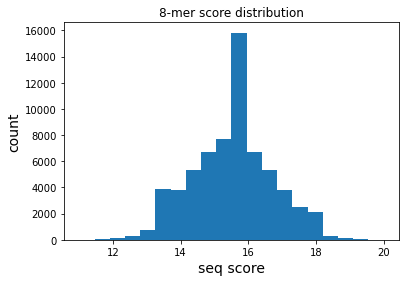

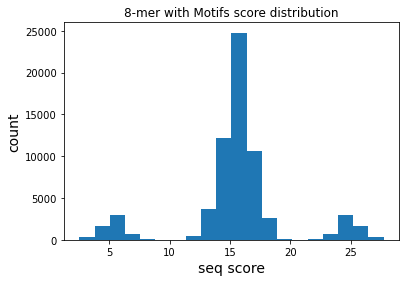

In [8]:
plt.hist(mer8['score'].values,bins=20)
plt.title("8-mer score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

plt.hist(mer8_motif['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### Define some basic model archs for Linear and CNN

In [9]:
class DNA_Linear_Shallow(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        
        #print("og shape?",xb.shape)
        #xb = xb.flatten()
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        #print("flattened shape?",xb.shape)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_Linear_Deep(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

In [10]:
def plot_train_test_hist(train_df, test_df,bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label="train")
    plt.hist(test_df['score'].values,bins=bins,label='test')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
    
def quick_test8(model, oracle):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        u.quick_seq_pred(model, seqs, oracle)
        print()

# Try with 8 mers

# Single task Regression with Motifs
### Linear Model

In [11]:
# mer8motif_train_df.to_csv("mer8motif_train_df.tsv",sep='\t')
# mer8motif_test_df.to_csv("mer8motif_test_df.tsv",sep='\t')

In [12]:
#mer8motif_train_df.head()

In [13]:
mer8motif_train_dl, \
mer8motif_test_dl, \
mer8motif_train_df, \
mer8motif_test_df = u.build_dataloaders_single(mer8_motif, batch_size=13)

In [14]:
mer8motif_train_df['oh'].values[0].shape

(8, 4)

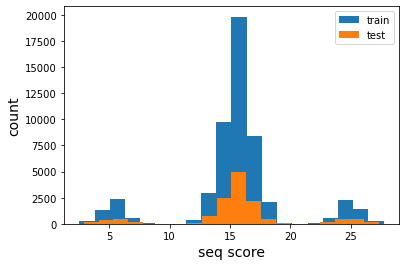

In [15]:
plot_train_test_hist(mer8motif_train_df, mer8motif_test_df,bins=20)

## Shallow Linear

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/torch/autograd/__init__.py:149: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/cuda/CUDAFunctions.cpp:115.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


0 12.824601523298515
1 12.768109162396907
2 12.719999301095251
3 12.777227958528451
4 12.823980014735982
5 12.769048845891659
6 12.87145418494367
7 12.75942463461204
8 12.816899328905524
9 12.720216171640356
10 12.763329767002213
11 12.77124286169936
12 12.778136017575727
13 12.742300301399178
14 12.829707780352154
15 12.867728081333736
16 12.733131769929749
17 12.780516158890572
18 12.768705708972558
19 12.728788660099712


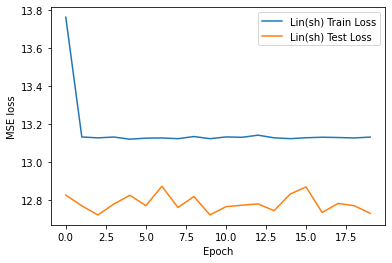

In [16]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_s = DNA_Linear_Shallow(seq_len)

mer8motif_train_losses_lin_s, mer8motif_test_losses_lin_s = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_s
)

# to plot loss
mer8motif_lin_s_data_label = list(zip([mer8motif_train_losses_lin_s,
                                       mer8motif_test_losses_lin_s], 
                                      ['Lin(sh) Train Loss',
                                       'Lin(sh) Test Loss']))
u.quick_loss_plot(mer8motif_lin_s_data_label)

In [17]:
dna = "GGGGGGGG"
dna_oh = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).float()
mer8motif_model_lin_s(dna_oh)

tensor([[7.3625]], grad_fn=<AddmmBackward>)

In [18]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_s,oracle_8mer_motif)

AAAAAAAA: pred:23.199 actual:20.000 (-3.199)
CCCCCCCC: pred:13.962 actual:17.000 (3.038)
GGGGGGGG: pred:7.363 actual:14.000 (6.637)
TTTTTTTT: pred:17.818 actual:11.000 (-6.818)

AACCAACA: pred:18.598 actual:18.875 (0.277)
CCGGCGCG: pred:10.250 actual:5.500 (-4.750)
GGGTAAGG: pred:13.982 actual:15.125 (1.143)
TTTCGTTT: pred:14.761 actual:12.125 (-2.636)
TGTAATAC: pred:19.454 actual:15.500 (-3.954)

TATAAAAA: pred:22.117 actual:27.750 (5.633)
CCTATCCC: pred:17.640 actual:25.875 (8.235)
GTATGGGG: pred:12.512 actual:24.000 (11.488)
TTTATTTT: pred:18.345 actual:22.125 (3.780)

AAGCGAAA: pred:16.598 actual:8.125 (-8.473)
CGCGCCCC: pred:12.664 actual:6.250 (-6.414)
GGGCGGGG: pred:8.215 actual:4.375 (-3.840)
TTGCGTTT: pred:12.710 actual:2.500 (-10.210)

ATATGCGA: pred:16.018 actual:15.875 (-0.143)
TGCGTATT: pred:14.776 actual:13.625 (-1.151)



## Deep Linear

0 8.422207042552147
1 3.517651392313486
2 2.4197527124709315
3 1.7740379513164901
4 1.8146736977333735
5 1.285314278755545
6 0.987969686579315
7 1.052348846303078
8 0.8007201814644895
9 0.8268112318069061
10 0.7021112625660795
11 3.2957971680262554
12 0.6656733226686998
13 0.49836070267702426
14 0.5778189666012485
15 0.48384299174847517
16 0.46830764132246905
17 0.4847169312380475
18 0.5116052172868747
19 0.5059416088740847


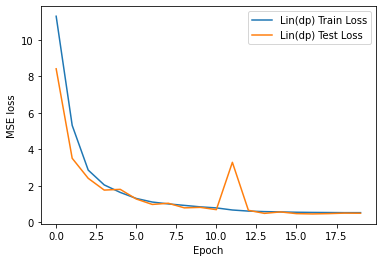

In [19]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_d = DNA_Linear_Deep(seq_len,hidden_layer_size)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_d
)

# to plot loss
mer8motif_lin_d_data_label = list(zip([mer8motif_train_losses_lin_d,
                                       mer8motif_test_losses_lin_d], 
                                      ['Lin(dp) Train Loss',
                                       'Lin(dp) Test Loss']))
u.quick_loss_plot(mer8motif_lin_d_data_label)

In [20]:
dna = "GGGGGGGG"
dna_oh = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).float()
mer8motif_model_lin_d(dna_oh)

tensor([[13.9237]], grad_fn=<ReluBackward1>)

In [21]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_d,oracle_8mer_motif)

AAAAAAAA: pred:20.039 actual:20.000 (-0.039)
CCCCCCCC: pred:17.102 actual:17.000 (-0.102)
GGGGGGGG: pred:13.924 actual:14.000 (0.076)
TTTTTTTT: pred:11.147 actual:11.000 (-0.147)

AACCAACA: pred:18.955 actual:18.875 (-0.080)
CCGGCGCG: pred:0.000 actual:5.500 (5.500)
GGGTAAGG: pred:14.923 actual:15.125 (0.202)
TTTCGTTT: pred:12.414 actual:12.125 (-0.289)
TGTAATAC: pred:16.003 actual:15.500 (-0.503)

TATAAAAA: pred:24.570 actual:27.750 (3.180)
CCTATCCC: pred:25.366 actual:25.875 (0.509)
GTATGGGG: pred:23.266 actual:24.000 (0.734)
TTTATTTT: pred:21.727 actual:22.125 (0.398)

AAGCGAAA: pred:8.104 actual:8.125 (0.021)
CGCGCCCC: pred:6.644 actual:6.250 (-0.394)
GGGCGGGG: pred:4.446 actual:4.375 (-0.071)
TTGCGTTT: pred:2.886 actual:2.500 (-0.386)

ATATGCGA: pred:15.129 actual:15.875 (0.746)
TGCGTATT: pred:14.329 actual:13.625 (-0.704)



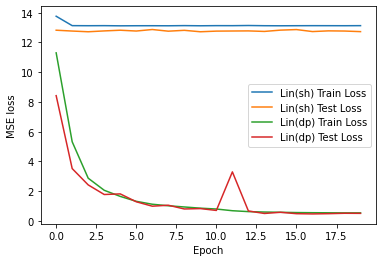

In [22]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label
)

### CNN Model

0 0.5259279900164817
1 0.168867332370725
2 0.02919442212957048
3 0.014976680015404841
4 0.04206005258864797
5 0.013427597666856982
6 0.022997107721326192
7 0.016117018229434104
8 0.004419106783912036
9 0.004006824480063604
10 0.004983427140480993
11 0.0031834816132108846
12 0.004609593060955218
13 0.002608219991670566
14 0.0021893203642388333
15 0.005094611199102794
16 0.0019812690038463485
17 0.0018150493426140506
18 0.0030328259303105455
19 0.004842815661127399


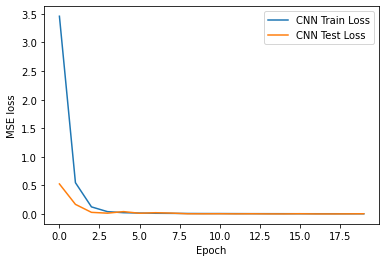

In [23]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnn = DNA_CNN(seq_len)

mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnn, 
    lr=0.01
)

# to plot loss
mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer8motif_cnn_data_label)

In [24]:
dna = "GGGGGGGG"
dna_oh = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).float()
mer8motif_model_cnn(dna_oh)

tensor([[13.9701]], grad_fn=<AddmmBackward>)

In [25]:
quick_test8(mer8motif_model_cnn, oracle_8mer_motif)

AAAAAAAA: pred:19.955 actual:20.000 (0.045)
CCCCCCCC: pred:16.987 actual:17.000 (0.013)
GGGGGGGG: pred:13.970 actual:14.000 (0.030)
TTTTTTTT: pred:11.017 actual:11.000 (-0.017)

AACCAACA: pred:18.860 actual:18.875 (0.015)
CCGGCGCG: pred:5.631 actual:5.500 (-0.131)
GGGTAAGG: pred:15.063 actual:15.125 (0.062)
TTTCGTTT: pred:12.155 actual:12.125 (-0.030)
TGTAATAC: pred:15.503 actual:15.500 (-0.003)

TATAAAAA: pred:27.444 actual:27.750 (0.306)
CCTATCCC: pred:25.856 actual:25.875 (0.019)
GTATGGGG: pred:23.974 actual:24.000 (0.026)
TTTATTTT: pred:22.180 actual:22.125 (-0.055)

AAGCGAAA: pred:8.096 actual:8.125 (0.029)
CGCGCCCC: pred:6.278 actual:6.250 (-0.028)
GGGCGGGG: pred:4.350 actual:4.375 (0.025)
TTGCGTTT: pred:2.631 actual:2.500 (-0.131)

ATATGCGA: pred:15.569 actual:15.875 (0.306)
TGCGTATT: pred:13.628 actual:13.625 (-0.003)



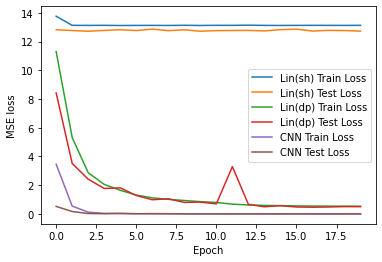

In [26]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label
)

In [27]:
def parity_pred(models, seqs, oracle,task,alt=True):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0)
            actual = oracle[dna]
            pred = model(s.float())
            data.append([dna,actual,pred.item()])
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        pearson = df['truth'].corr(df['pred'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            u.alt_parity_plot(model_name, df, pearson,task)
        u.parity_plot(model_name, df, pearson)

    return dfs

Running LinearShallow_8mer


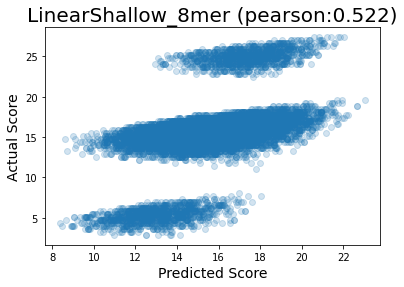

Running LinearDeep_8mer


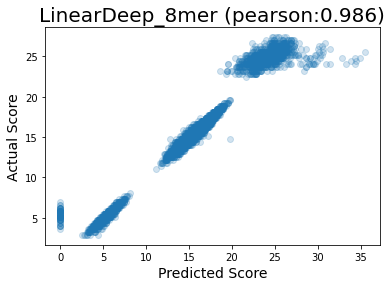

Running CNN_8mer


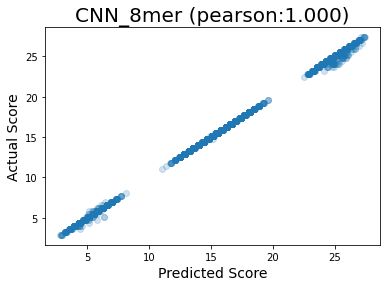

In [28]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s),
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

dfs = parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)

# try to export to keras

In [29]:
mer8motif_model_cnn

DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 31, kernel_size=(4, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=186, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [30]:
mer8motif_model_cnn

DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 31, kernel_size=(4, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=186, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [31]:
mer8motif_model_lin_d

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=24, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): ReLU(inplace=True)
  )
)

# Try onnx export

In [32]:
seqs = ["AAAAAAAA","TTTTTTTT","CCCCCCCC","GGGGGGGG","GGGTATGG","AAGCGAAA"]
# ohe_seqs = [u.one_hot_encode(x) for x in seqs]

In [44]:
# dummy_input = torch.from_numpy(ohe_seqs[0].reshape(1, -1)).float()
# dummy_output = mer8motif_model_lin_d(dummy_input)
# print(dummy_output)

In [45]:
# dna = "GGGGGGGG"
# dna_oh = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).float()
# dna_oh = torch.from_numpy(u.one_hot_encode(dna)).unsqueeze(0).float()

In [46]:
# print(dna_oh.shape)
# print(dummy_input.shape)

In [47]:
# dummy_input = torch.from_numpy(ohe_seqs[0].reshape(1, -1)).float()
# dummy_input.shape

In [48]:
# print(mer8motif_model_lin_d(dummy_input))
# print(mer8motif_model_lin_d(dna_oh))

In [49]:
# print(mer8motif_model_cnn(dna_oh))
# print(mer8motif_model_cnn(dummy_input))


In [33]:
import keras
import onnx
import onnx2keras
from onnx2keras import onnx_to_keras

Using TensorFlow backend.
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [52]:
def export2keras(pt_model, model_name_str,example_seqs):
    
    # make dummy input from example seqs
    ohe_seqs = [u.one_hot_encode(x) for x in example_seqs]
    #ohe_seqs = [torch.from_numpy(x.reshape(1, -1)).unsqueeze(0).float() for x in ohe_seqs]
    ohe_seqs = [torch.from_numpy(x).unsqueeze(0).float() for x in ohe_seqs]
    #dummy_input = torch.from_numpy(ohe_seqs[0].reshape(1, -1)).float()
    dummy_input = ohe_seqs[0]
    
    # export intermediate ONNX model
    onnx_model_str = f"{model_name_str}.onnx"
    torch.onnx.export(
        pt_model, 
        dummy_input, 
        onnx_model_str, 
        input_names=['test_input'], # should this change? Does it matter?
        output_names=['test_output']
    )
    print("Done saving to onnx.")
    print("Loading to Keras...")
    
    # convert ONNX to keras
    onnx_model = onnx.load(onnx_model_str)
    k_model = onnx_to_keras(onnx_model, ['test_input'])
    
    print("confirming Torch and Keras match")
    # confirm Pytorch and Keras agree
    for i in range(len(example_seqs)):
        #ohe_seq = np.array(u.one_hot_encode(seq))
        #ohe_seq1 = torch.Tensor(u.one_hot_encode(seq)).unsqueeze(0)
        #ohe_seq2 = np.array(torch.from_numpy(u.one_hot_encode(seq).reshape(1, -1)).float())
        seq = example_seqs[i]
        ohe_seq = ohe_seqs[i]
        seq_k = np.array(ohe_seq)

        res = pt_model(ohe_seq)
        res2 = k_model.predict(seq_k)
        
        print(f"{seq}:{res.item()}, {res2[0]}")
        
    # save the Keras model
    k_model_str = f"{model_name_str}.h5"
    
    k_model.save(k_model_str)
    k_reload = keras.models.load_model(k_model_str)
    print(k_reload)
    print(f"Keras Model saved at {k_model_str}")


In [53]:
export2keras(mer8motif_model_lin_d, "mer8motif_model_lin_d",seqs)

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> test_input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> test_output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight lin.0.weight with shape (24, 32).
DEBUG:onnx2keras:Found weight lin.0.bias with shape (24,).
DEBUG:onnx2keras:Found weight lin.2.weight with shape (1, 24).
DEBUG:onnx2keras:Found weight lin.2.bias with shape (1,).
DEBUG:onnx2keras:Found weight 17 with shape (1,).
DEBUG:onnx2keras:Found input test_input with shape [8, 4]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Shape
DEBUG:onnx2keras:node_name: 5
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name test_input).
DEBUG:onnx2k

Done saving to onnx.
Loading to Keras...


DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Gemm
DEBUG:onnx2keras:node_name: 15
DEBUG:onnx2keras:node_params: {'alpha': 1.0, 'beta': 1.0, 'transB': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 14).
DEBUG:onnx2keras:Check input 1 (name lin.2.weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 2 (name lin.2.bias).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:gemm:Convert GEMM with bias.
DEBUG:onnx2keras:gemm:Transposing W matrix.
DEBUG:onnx2keras:gemm:Input units 24, output units 1.
DEBUG:onnx2keras:Output TF Layer -> Tensor("15_2/BiasAdd:0", shape=(?, 1), dtype=float3

confirming Torch and Keras match
AAAAAAAA:20.03873634338379, [20.03874]
TTTTTTTT:11.146650314331055, [11.1466465]
CCCCCCCC:17.101852416992188, [17.101852]
GGGGGGGG:13.923650741577148, [13.923651]
GGGTATGG:23.0411319732666, [23.041128]
AAGCGAAA:8.103906631469727, [8.103909]
Keras Model saved at mer8motif_model_lin_d.h5


/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [54]:
export2keras(mer8motif_model_cnn, "mer8motif_model_cnn",seqs)

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> test_input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> test_output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight conv_net.0.weight with shape (31, 1, 4, 3).
DEBUG:onnx2keras:Found weight conv_net.0.bias with shape (31,).
DEBUG:onnx2keras:Found weight conv_net.3.weight with shape (10, 186).
DEBUG:onnx2keras:Found weight conv_net.3.bias with shape (10,).
DEBUG:onnx2keras:Found weight conv_net.5.weight with shape (1, 10).
DEBUG:onnx2keras:Found weight conv_net.5.bias with shape (1,).
DEBUG:onnx2keras:Found input test_input with shape [8, 4]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Transpose
DEBUG:onnx2keras:node_name: 7
DEBUG:onnx2keras:node_params: {'perm': [0, 2, 1], 'change_ordering': False, 'name_policy': None}
DEB

Done saving to onnx.
Loading to Keras...


DEBUG:onnx2keras:Output TF Layer -> Tensor("12_7/BiasAdd:0", shape=(?, 10), dtype=float32)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: 13
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 12).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:Output TF Layer -> Tensor("13_5/Relu:0", shape=(?, 10), dtype=float32)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Gemm
DEBUG:onnx2keras:node_name: test_output
DEBUG:onnx2keras:node_params: {'alpha': 1.0, 'beta': 1.0, 'transB': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 13).
DEBUG:onnx2keras:Check input 1 (name conv_net.5.wei

confirming Torch and Keras match
AAAAAAAA:19.95490837097168, [19.954908]
TTTTTTTT:11.017036437988281, [11.017038]
CCCCCCCC:16.987394332885742, [16.987394]
GGGGGGGG:13.970064163208008, [13.970064]
GGGTATGG:23.96986198425293, [23.969864]
AAGCGAAA:8.096443176269531, [8.096444]


TypeError: ('Keyword argument not understood:', 'module')

In [51]:
print(onnx2keras.__version__)

AttributeError: module 'onnx2keras' has no attribute '__version__'

In [49]:
k_reload = keras.models.load_model("mer8motif_model_cnn.h5")


TypeError: ('Keyword argument not understood:', 'module')

# inspect

# 8mer model cnn

In [37]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()

Total convolutional layers: 1


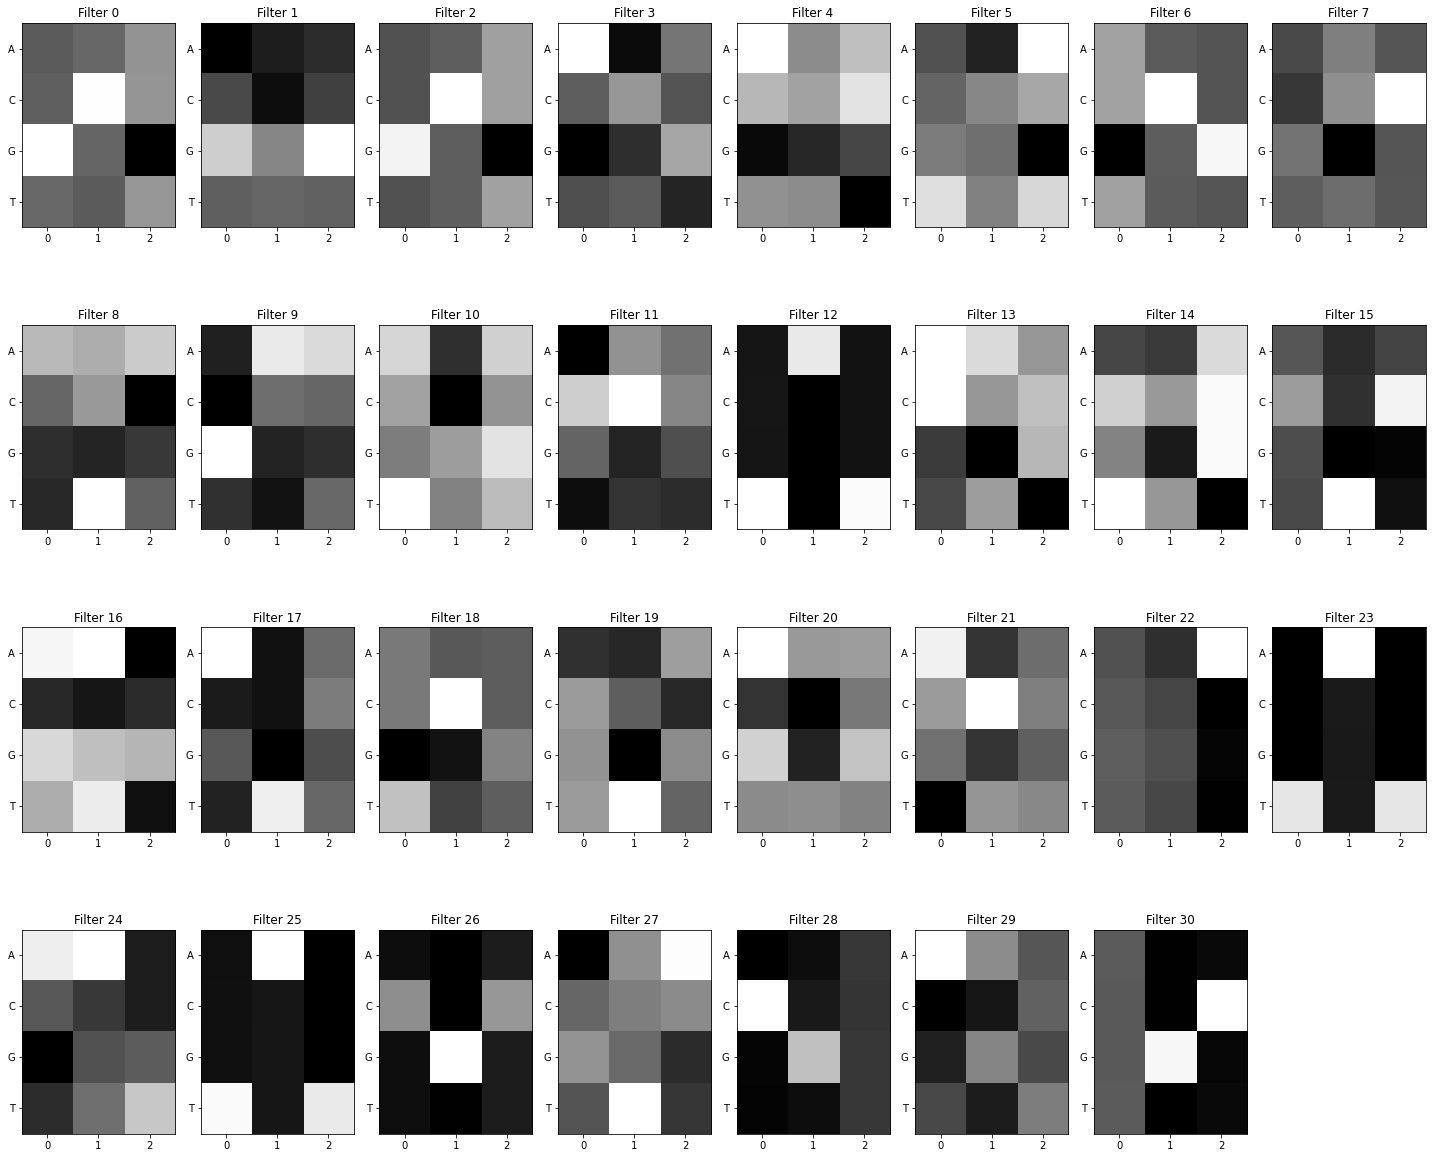

In [38]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(mer8motif_model_cnn)
view_filters(model_weights)

In [39]:
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

In [40]:
#train_seqs = list(mer8motif_train_df['seq'])# still using mer6 seqs is ok cuz just getting activations!
seqs8_5k = u.downselect_list(seqs8,5000)

In [41]:
filter_activations = get_filter_activations(seqs8_5k, conv_layers[0])

Num filters 31
filt_width 3
Running seq AGGTCGGA
Running seq AAAAACAG
Running seq TTGTGGAG
Running seq AGCTAGGC
Running seq AACTTATA
Running seq GGCAGCCC
Running seq TTAGCCTA
Running seq GCAACGCC
Running seq ATGTCTGT
Running seq CGGCACGT
Running seq CGCCTTAC
Running seq GTAAATAA
Running seq TTGGGGCA
Running seq TAAGCAGA
Running seq GGCATCAA
Running seq GACGACAG
Running seq AATACCTA
Running seq GCGTTCGT
Running seq AGCGTACC
Running seq TGCGTCAA
Running seq AAACCTTG
Running seq TCAGCGAG
Running seq AGCAAGGT
Running seq GTATCCCA
Running seq CTAACTAA
Running seq AACAAACC
Running seq AGCGCCCA
Running seq GCTCCGTA
Running seq ACAGGCGA
Running seq TCCTGAGC
Running seq GAGTAGTG
Running seq AACCTTTA
Running seq GGGTTCCG
Running seq GGTACTGC
Running seq AGCCTTTT
Running seq TCCTCACT
Running seq CTCGCCAT
Running seq ACGTATCG
Running seq TCGGCTAT
Running seq CGGATGAT
Running seq CGCTCCGA
Running seq AAATGTCA
Running seq AAGGTTTC
Running seq GAGGAGCT
Running seq TCCCATAT
Running seq CATCTTGA
Runnin

Running seq GGCCAAGA
Running seq CACGGACT
Running seq ATCGTCTA
Running seq GGGCCTGT
Running seq CCGGATCG
Running seq AGTCGAGC
Running seq CCTGCTCT
Running seq AGGTACGA
Running seq ATTCCTTC
Running seq CCTCGTCG
Running seq CAACAGGA
Running seq TTAGCTGC
Running seq ACCGCGTG
Running seq GATCTAGT
Running seq CATGAGGT
Running seq CCGGGACC
Running seq TTCAAGGA
Running seq AGGCCTTG
Running seq CGGCTAAT
Running seq TGCTTTTC
Running seq TGGAGTTT
Running seq TGTTAGAG
Running seq TGCCAGAA
Running seq GGCACAGG
Running seq GAAGCGTG
Running seq ACACTATA
Running seq ACACGACT
Running seq CATACTTG
Running seq CTATCAAC
Running seq TCTTACGG
Running seq CGCGTTAT
Running seq GTTGCGTG
Running seq AAGTGGAT
Running seq TAAAGTCC
Running seq GTGGCTTA
Running seq GCGCTGGA
Running seq TTTCCTAT
Running seq AGCTCAGA
Running seq AGGACCGT
Running seq TGGACTGG
Running seq CGGTCAGG
Running seq CGTCTTCT
Running seq CCCCGTTG
Running seq TTACAACC
Running seq AATTGGCT
Running seq ACCCCCGT
Running seq GCGACGAT
Running seq A

Running seq TAGATGAT
Running seq CGCTAGAC
Running seq GGTTGCCC
Running seq ACGCGGGG
Running seq CTGGTGAA
Running seq CCTCAACT
Running seq AAGCCCAC
Running seq TAGCGTTT
Running seq TTCGGGGT
Running seq TATCTCTC
Running seq GCAGTCAG
Running seq GACTTGTA
Running seq ATTATAGT
Running seq CCTTACTA
Running seq GGTATCGT
Running seq AATGGGTC
Running seq CACGCGGT
Running seq GGGCCTGA
Running seq GCGGAGGC
Running seq CGCGATCG
Running seq AAGGCAGG
Running seq CGTTAGTC
Running seq ACTGTTTC
Running seq CTTTTCTG
Running seq TAATGGCA
Running seq AAATACCC
Running seq AACTCCTT
Running seq CTCACCGC
Running seq TTCGGAGT
Running seq ATGTGCAA
Running seq ATAGAGGA
Running seq AGGCGACT
Running seq GTATCAAG
Running seq CAGAATCA
Running seq ATTACAGA
Running seq TTGACAGC
Running seq ATGTGTGG
Running seq TCTCCTCT
Running seq TGGTGACA
Running seq CTCGTGCG
Running seq TCACTATC
Running seq TAATCCTC
Running seq CTCATGTG
Running seq CAGTACAT
Running seq ACGACGAC
Running seq AGGGAAAA
Running seq CCTTTTGT
Running seq T

Running seq CTGTCCCA
Running seq GGACGGCA
Running seq TGATCGGT
Running seq CCAGTTCA
Running seq GCTGGACT
Running seq CCTACGCC
Running seq GCCTACGA
Running seq TAAGATCG
Running seq TGAATCCA
Running seq GCTTTCGG
Running seq TTTCATTG
Running seq CTGAAATG
Running seq TACCACCC
Running seq GGTAACGT
Running seq CGTTTCGC
Running seq GGTCGAAT
Running seq GCCGGAGG
Running seq AACTTCCA
Running seq AGATCTGC
Running seq AGCCGCGA
Running seq ATGTCTCG
Running seq CGTGAATG
Running seq GCGGAACA
Running seq GGACCCTA
Running seq CGGCACCA
Running seq GCGAGTAG
Running seq GGTGGCAC
Running seq GGTTGGGT
Running seq ATCTGATC
Running seq CGACCCAA
Running seq TTGGTGAG
Running seq ACGTGAAT
Running seq GTGGGATG
Running seq TCTATAAC
Running seq AAGGCATC
Running seq TAAGCGTA
Running seq CATCAGGG
Running seq CACCCTTC
Running seq CACGGCGT
Running seq GTGCGATG
Running seq AAAGTACG
Running seq CGTTAGCT
Running seq CGACTCCA
Running seq TGCTTGTG
Running seq GAGCAGGC
Running seq TGTCTTCC
Running seq TGGACGAA
Running seq A

Running seq TATGCCTA
Running seq TTTTAGGC
Running seq CGTACTCG
Running seq CTACAGCC
Running seq TGTGCACG
Running seq AATTCGGG
Running seq TACGGGAC
Running seq GAGACCTC
Running seq TGATGATT
Running seq CGGTCATA
Running seq GTTTAGAT
Running seq ACGGCTTT
Running seq GGCCTGTC
Running seq TTCTCCGT
Running seq CTGGTCAA
Running seq GAGGATGC
Running seq CACGGTCA
Running seq GCAAACCA
Running seq ACGCGCAC
Running seq TTTTTTAG
Running seq CCGAATAG
Running seq AAGCCTGC
Running seq TTTCAACA
Running seq CGATCCCG
Running seq TGAGTCCT
Running seq TCAAAGAA
Running seq CCGAGAAT
Running seq CTTGTAGA
Running seq ACCTAATG
Running seq CGATTCCC
Running seq TGAGTTGA
Running seq ACACTGGT
Running seq TAGACATC
Running seq CCAAATGG
Running seq ACAACCGC
Running seq CCGGGCAA
Running seq GGCAGACT
Running seq CCCTAATC
Running seq GGCCTCAT
Running seq GATGGTGC
Running seq AACCCTGG
Running seq GCGGTACT
Running seq GTCAGCAG
Running seq CCTATCGA
Running seq CCTCCTCA
Running seq TCGCCGAC
Running seq ACAACCAT
Running seq C

Running seq AGGTTAGC
Running seq ACGAGCTT
Running seq CATAGGCC
Running seq CGAGTAAG
Running seq GCAGGCTA
Running seq GATGGCTC
Running seq ACATTGAT
Running seq TCTCGCTA
Running seq AGAGGGGC
Running seq TCATAGGA
Running seq CAGTCTAT
Running seq AATTAATG
Running seq TTCTCTTG
Running seq ATTCGCAA
Running seq ACTACGTC
Running seq GGGTGACA
Running seq CACGCTGA
Running seq CCTCGACC
Running seq GATCTTTG
Running seq TCGCAACG
Running seq CCTAAATC
Running seq CAGACCCC
Running seq GTGATTCA
Running seq GTTTACTC
Running seq GAAGTGTG
Running seq TTGTGTGG
Running seq ACTGTCGC
Running seq GCGGCCGA
Running seq TCATGGAA
Running seq TGCCTGCC
Running seq TCGCCGCT
Running seq CGCCTTTC
Running seq CCTAACCG
Running seq TACGGACA
Running seq CCGTCTCA
Running seq ACGACAAA
Running seq GACGGTTC
Running seq CTCCAATG
Running seq ATTTGATG
Running seq TCTAAAGA
Running seq TGAAGGCT
Running seq CGCTGACG
Running seq AAGGTCGA
Running seq TTTTGGCT
Running seq TGCCAAAT
Running seq ACATGTAG
Running seq AATCTAAT
Running seq G

Running seq AAAACAAT
Running seq TGAAAAGA
Running seq CTGCTTAA
Running seq CTAGTAAA
Running seq GCGATTCT
Running seq AGCGTGGC
Running seq TAGCAGAA
Running seq CAGACTGT
Running seq GTCATTGT
Running seq GGAACTGA
Running seq TAAGAATC
Running seq GCGTGACC
Running seq GAGTACCC
Running seq AGGTTTTG
Running seq CCAGCGTC
Running seq CGCCCCCG
Running seq GATATTAT
Running seq CTTTTCAC
Running seq AAGTGCTC
Running seq CGCGAGGA
Running seq CTTAGTCT
Running seq AATCAGTA
Running seq GATAGTTA
Running seq CCAGGTGA
Running seq TGTATGTA
Running seq TATAGTTT
Running seq GGGGTAGA
Running seq TCCCGGCC
Running seq TACCCCTG
Running seq GAGAGGCA
Running seq TTATGACG
Running seq TAATATAC
Running seq CGTCTCGT
Running seq GCTGCTGA
Running seq TAGCCTCC
Running seq GCACTATC
Running seq GAGCAGGG
Running seq ACCGAAGT
Running seq TGAGGTCA
Running seq TGTGTTCT
Running seq CGTATCCA
Running seq CTCGTGCT
Running seq ACACCTAA
Running seq GTAATTGT
Running seq TCACCTGA
Running seq TAGAGCAA
Running seq GCGTAAGT
Running seq T

Running seq CTAACTAG
Running seq CGCGCACG
Running seq CAGTTGCT
Running seq TTCAACAA
Running seq AATGAACA
Running seq TTGGCCCC
Running seq GACAGCTG
Running seq CCTCAATA
Running seq GACGCCCC
Running seq AAACGCGA
Running seq GGTGCGGT
Running seq ATTTAAAA
Running seq CGGTATAC
Running seq AGCCGTAG
Running seq ATGGATAA
Running seq AGGGCCAG
Running seq CACCTGGT
Running seq ACCGTGCT
Running seq TTCCTTCC
Running seq CAGAAGCC
Running seq CCACACCG
Running seq ACGCATCG
Running seq ATGCGGTC
Running seq GTCGCAGG
Running seq CTGAGGCT
Running seq TTCGGATT
Running seq AGGGTCTA
Running seq CACGACGC
Running seq CATTTGCG
Running seq CTAAGTGG
Running seq TCGAAGAA
Running seq GAAAGTCG
Running seq AAGCTGTG
Running seq AGCCAACG
Running seq TTTACTAA
Running seq CCACCTCA
Running seq AAGAGCCT
Running seq GTCCGGCG
Running seq AACTGTAT
Running seq TTGATAAA
Running seq ACAGGCCT
Running seq ACTTTTCC
Running seq GGAGCTCT
Running seq TAATAAGA
Running seq TAATCCAG
Running seq ACCAGCGT
Running seq GTGTCAAT
Running seq G

Running seq CCAGAGTG
Running seq TCCCTGAG
Running seq AAACTCTG
Running seq AATGCTTT
Running seq TCGTGATT
Running seq CATCCCCC
Running seq AATTGCTA
Running seq GCCTGGAC
Running seq TGACAAAC
Running seq CAGGATCC
Running seq GTTCAGAC
Running seq TGTCTCTT
Running seq TCATTGTT
Running seq CCCTTTTG
Running seq CTTCCACC
Running seq TGCCAGGA
Running seq AGCAGAAG
Running seq TATGGAGG
Running seq GACAACAA
Running seq CTATATTA
Running seq CTAGGTGC
Running seq TGTCAGAC
Running seq AAAACCGT
Running seq TACTTCAG
Running seq TTTACTGC
Running seq ACGCTGCC
Running seq GCCTCAAT
Running seq CTCAGACT
Running seq GGTGAGTC
Running seq GAGTATTT
Running seq GTCGGACT
Running seq TTTCTCCG
Running seq GACAACGA
Running seq CATTGCAG
Running seq TCAAGTGG
Running seq CCCCGTCT
Running seq CCCTACGT
Running seq GTGCGTTT
Running seq CATAGTGG
Running seq TGCAATGT
Running seq GAAAAATA
Running seq CCATTATA
Running seq CGTGTTGC
Running seq GTGGGACT
Running seq AACGCAAG
Running seq ATCCTCGG
Running seq CACCTTCG
Running seq A

Running seq ATTGGGCT
Running seq GCAAGGTT
Running seq TACTTTAA
Running seq CCGGCTAC
Running seq CCTGTAAC
Running seq ATAAGGAC
Running seq GACAGATA
Running seq CTTTGAAT
Running seq GCTTTGAA
Running seq ACCGTACG
Running seq GGGTAGAG
Running seq TCTGATAA
Running seq CGTCTACA
Running seq AACGTGCT
Running seq CGTTCAGC
Running seq TACTTCCG
Running seq CTCGTCAC
Running seq ACTGCGAA
Running seq CGCGAGTT
Running seq ACGTCTGT
Running seq CCGAGGAC
Running seq GCTCAAAT
Running seq GCCCGTTC
Running seq CGCGGAAC
Running seq GTTACTGG
Running seq TCTAGCGC
Running seq TTGATCTG
Running seq ACAGCTTA
Running seq GTTTCCCG
Running seq GGATGTAG
Running seq AAGAAACG
Running seq TATGATGG
Running seq TAATGGGA
Running seq TAGTCCTA
Running seq TTACGGTG
Running seq TTTAAGGG
Running seq GTGAGATG
Running seq GCCAACGT
Running seq GCACTTCT
Running seq GCTAGCAC
Running seq AACGCTAC
Running seq AAGGTCAT
Running seq GTAGCACA
Running seq TTTATAAG
Running seq GGGCTTTA
Running seq AGATGAAG
Running seq GTAATGGC
Running seq A

Running seq CAACCTAC
Running seq ATTCACAA
Running seq GTTATCCA
Running seq GTAAAGTT
Running seq TCTGCTGG
Running seq CGATAAAC
Running seq GCTGCGCC
Running seq ATATGCGG
Running seq TAAGCAAG
Running seq CTTGCGGT
Running seq TCCCGATA
Running seq CCTGTTCA
Running seq GAGTCCAG
Running seq CACTTATC
Running seq GCGTGCTG
Running seq ATGAACAG
Running seq TAATCCGA
Running seq TTCCCCGC
Running seq TGAGCAGT
Running seq ATATTTGT
Running seq TCAACACG
Running seq TGGAACTA
Running seq ATACAGGG
Running seq CGTGAGAG
Running seq GGTCTCCG
Running seq TAATACAT
Running seq AGGTAGTT
Running seq CGTGATTA
Running seq GTTTTATT
Running seq CCTAGTCT
Running seq CACTTCGT
Running seq CTGTGATT
Running seq CAGCCACT
Running seq CATTGGTC
Running seq CGAGCCCA
Running seq AGCACTTT
Running seq TTCGTCCC
Running seq TTCCGCTC
Running seq CAAAGCAA
Running seq CGCGATTA
Running seq CTCCTCTA
Running seq ATCCGTCT
Running seq TCAACTAT
Running seq TATCTATC
Running seq GGTATACT
Running seq ATGGGCCC
Running seq GCTTGACA
Running seq A

Running seq GAGTTTAC
Running seq CGAGAGGG
Running seq TATTTCTC
Running seq CAGCTTTG
Running seq AATTGGCG
Running seq CTGGATCG
Running seq ATCAGTCC
Running seq TTCCTTTC
Running seq GGTACGGT
Running seq GGGCTGGC
Running seq GTGGTTCC
Running seq AGTCTACA
Running seq AACGCGCA
Running seq AGCGTAAA
Running seq TTTATCGA
Running seq GCCCTAGA
Running seq GTGAGAAG
Running seq GTCGCCCA
Running seq TACCGAAA
Running seq AAGGATGA
Running seq TCCACTTC
Running seq CGGTCGAA
Running seq GTTACTCC
Running seq AACCAAGG
Running seq TTATGCCT


In [42]:
def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(3))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

In [45]:
import logomaker

torch.Size([31, 4, 3])


/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([y

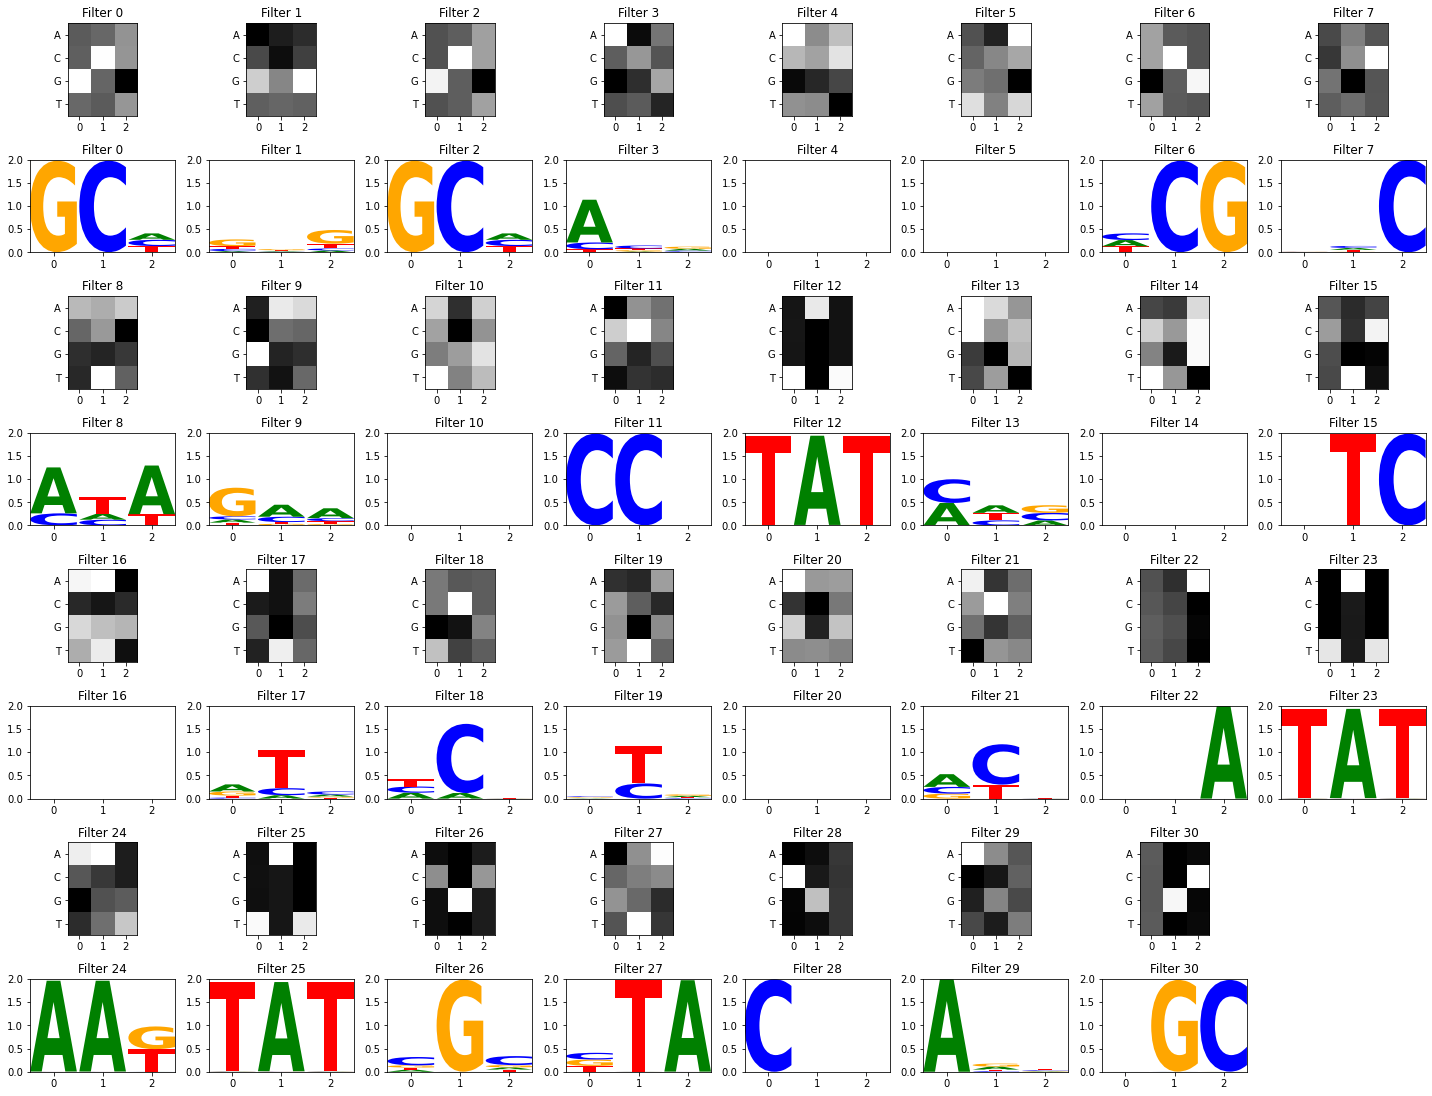

In [46]:
view_filters_and_logos(model_weights,filter_activations)

# Try LSTMs

In [46]:
# mer8motif_train_dl,\
# mer8motif_test_dl, \
# mer8motif_train_df, \
# mer8motif_test_df = u.build_dataloaders_single(mer8_motif,batch_size=11)
# change to batch size 11 so I can figure out the dimension errors

In [47]:
# class DNA_LSTM(nn.Module):
#     def __init__(self,
#                  seq_len,
#                  hidden_dim=10,
#                  layer1_dim=12,
#                  #layer2_dim=12
#                 ):
#         super().__init__()
#         self.seq_len = seq_len
#         self.hidden_dim = hidden_dim
        
#         self.hidden_init_values = None
#         self.hidden = self.init_hidden() # tuple of hidden state and cell state
        
#         self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
# #         self.fc = nn.Sequential(
# #             nn.ReLU(inplace=True),
# #             #nn.Flatten(),
# #             nn.Linear(hidden_dim, layer1_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Linear(layer1_dim, 1),
# #         )
#         self.fc = nn.Linear(hidden_dim, 1)
            
# #         self.rnn = nn.Sequential(
# #             nn.LSTM(4, hidden_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Flatten(),
# #             nn.Linear(hidden_dim, layer1_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Linear(layer1_dim, 1),
# #         ) 
    
#     def init_hidden(self):
#         if self.hidden_init_values == None:
#             self.hidden_init_values = (autograd.Variable(torch.randn(1, 1, self.hidden_dim)),
#                                        autograd.Variable(torch.randn(1, 1, self.hidden_dim)))
#         return self.hidden_init_values
#         #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

#     def forward(self, xb):
#         # WRONG? reshape view to batch_ssize x 4channel x seq_len
#         # for LSTM? reshape view to seq_len x batch_ssize x 4channel  
#         # permute to put channel in correct order
#         print("original xb.shape:", xb.shape)
#         print(xb)
#         xb = xb.view(-1,self.seq_len,4)#.permute(1,0,2) 
#         print("re-viewed xb.shape:", xb.shape) # >> 11, 8, 4
#         print(xb)
#         #print(xb[0])
#         #print("xb shape", xb.shape)

#         # ** Init hidden temp **
#         batch_size = xb.shape[0]
#         print("batch_size:",batch_size)
#         (h, c) =  (torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim)) 
#         # *******
        
#         lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
#         print("lstm_out",lstm_out)
#         print("^^^^^lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
#         print("lstm_out[-1] shape:",lstm_out[-1].shape)
#         print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape)
#         print("hidden len:",len(self.hidden))
#         print("hidden[0] shape:", self.hidden[0].shape)
#         print("hidden[0][-1] shape:", self.hidden[0][-1].shape)
#         print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape)
        
#         print("*****")
#         A = lstm_out[-1][-1]
#         B = self.hidden[0][-1][-1]
#         print("lstm_out[-1][-1]:",A)
#         print("self.hidden[0][-1][-1]",B)
#         print("==?", A==B)
#         print("*****")
        
#         #linear_in = lstm_out.contiguous().view(-1, self.hidden_dim)
#         #print("Linear In shape:", linear_in.shape)
#         #print("self.hidden",self.hidden)
#         #print(self.hidden[1].shape)
#         #out = self.fc(linear_in)
#         out = self.fc(lstm_out)
#         #print("out",out)
#         print("LSTM->FC out shape:",out.shape)
#         return out

In [48]:
class DNA_LSTM(nn.Module):
    def __init__(self,seq_len,hidden_dim=10):
        super().__init__()
        self.seq_len = seq_len

        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            

    
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

    def forward(self, xb,verbose=False):
        if verbose:
            print("original xb.shape:", xb.shape)
            print(xb) # 11 x 32
        
        # make the one-hot nucleotide vectors group together
        xb = xb.view(-1,self.seq_len,4) 
        if verbose:
            print("re-viewed xb.shape:", xb.shape) # >> 11 x 8 x 4
            print(xb)

        # ** Init hidden/cell states?? **
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
         
        # *******
        
        lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
        if verbose:
            #print("lstm_out",lstm_out)
            print("lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
            print("lstm_out[-1] shape:",lstm_out[-1].shape) # >> 8 x 10
            print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape) # 10

            print("hidden len:",len(self.hidden)) # 2
            print("hidden[0] shape:", self.hidden[0].shape) # >> 1 x 11 x 10
            print("hidden[0][-1] shape:", self.hidden[0][-1].shape) # >> 11 X 10
            print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape) # >> 10

            print("*****")
            # These vectors should be the same, right?
            A = lstm_out[-1][-1]
            B = self.hidden[0][-1][-1]
            print("lstm_out[-1][-1]:",A)
            print("self.hidden[0][-1][-1]",B)
            print("==?", A==B)
            print("*****")
        
        # attempt to get the last layer from each last position of 
        # all seqs in the batch? IS this the right thing to get?
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        #last_layer = lstm_out[-1][-1].unsqueeze(0) # this was [10X1]? led to FC outoput being [1]?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)   
                                                
        return out

In [50]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_lstm = DNA_LSTM(seq_len)
mer8motif_model_lstm

DNA_LSTM(
  (rnn): LSTM(4, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [51]:
mer8motif_train_losses_lstm,\
mer8motif_test_losses_lstm = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lstm
)


0 5.482639772272397
1 0.20720879422079547
2 0.10304451005793096
3 0.061557350766912974
4 0.06122919900580413
5 0.04016574221205047
6 0.044529777883259576
7 0.029307279102393415
8 0.028446515313149873
9 0.02376602609189404
10 0.03057173010807906
11 0.019461014381394432
12 0.02092862046221547
13 0.01722342472791025
14 0.015123907362735016
15 0.017284561186201294
16 0.01562197680638658
17 0.013244265430012355
18 0.011806105203458487
19 0.011503140126913588


In [52]:
quick_test8(mer8motif_model_lstm, oracle_8mer_motif)

AAAAAAAA: pred:19.669 actual:20.000 (0.331)
CCCCCCCC: pred:17.031 actual:17.000 (-0.031)
GGGGGGGG: pred:13.976 actual:14.000 (0.024)
TTTTTTTT: pred:10.856 actual:11.000 (0.144)

AACCAACA: pred:18.904 actual:18.875 (-0.029)
CCGGCGCG: pred:5.525 actual:5.500 (-0.025)
GGGTAAGG: pred:15.201 actual:15.125 (-0.076)
TTTCGTTT: pred:12.082 actual:12.125 (0.043)
TGTAATAC: pred:15.513 actual:15.500 (-0.013)

TATAAAAA: pred:27.596 actual:27.750 (0.154)
CCTATCCC: pred:25.732 actual:25.875 (0.143)
GTATGGGG: pred:23.787 actual:24.000 (0.213)
TTTATTTT: pred:21.512 actual:22.125 (0.613)

AAGCGAAA: pred:8.075 actual:8.125 (0.050)
CGCGCCCC: pred:6.440 actual:6.250 (-0.190)
GGGCGGGG: pred:4.335 actual:4.375 (0.040)
TTGCGTTT: pred:2.910 actual:2.500 (-0.410)

ATATGCGA: pred:16.169 actual:15.875 (-0.294)
TGCGTATT: pred:14.399 actual:13.625 (-0.774)



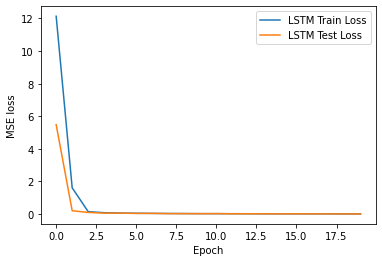

In [53]:
mer8motif_lstm_data_label = list(zip([mer8motif_train_losses_lstm,mer8motif_test_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(mer8motif_lstm_data_label)

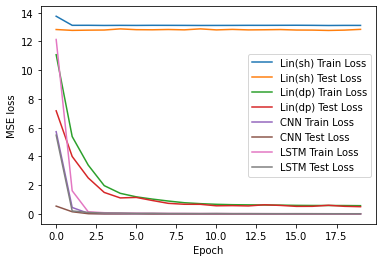

In [54]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label
)

# Try CNN + LSTM

In [55]:
class DNA_CNNLSTM(nn.Module):
    def __init__(self,
                 seq_len,
                 hidden_dim=10,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
        ) 
        
        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(num_filters, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)

    def forward(self, xb, verbose=False):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        if verbose:
            print("xb reviewed shape:",xb.shape)

        cnn_out = self.conv_net(xb)
        if verbose:
            print("CNN out shape:",cnn_out.shape)
        cnn_out_perm = cnn_out.permute(0,2,1)
        if verbose:
            print("CNN permute out shape:",cnn_out_perm.shape)
        
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
        
        lstm_out, self.hidden = self.rnn(cnn_out_perm, (h,c)) # should this get H and C?
        
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)        
        
        return out

In [56]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnnlstm = DNA_CNNLSTM(seq_len)
mer8motif_model_cnnlstm

DNA_CNNLSTM(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
  )
  (rnn): LSTM(32, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [57]:
mer8motif_train_losses_cnnlstm,\
mer8motif_test_losses_cnnlstm = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnnlstm, 
)


0 0.0876547576336879
1 0.04249958451001044
2 0.02413250248075122
3 0.020523843873359846
4 0.012054300003604487
5 0.009947507342254459
6 0.009897500425468457
7 0.007924331076627428
8 0.006866361782377193
9 0.005744689862122655
10 0.005593913472983863
11 0.005798697677849976
12 0.004691510910346377
13 0.004572586285285802
14 0.004020758334145565
15 0.003920946594956729
16 0.0037218595322445398
17 0.0037923764930274948
18 0.0035863559552632342
19 0.0032435089164590566


AAAAAAAA: pred:19.817 actual:20.000 (0.183)
CCCCCCCC: pred:16.987 actual:17.000 (0.013)
GGGGGGGG: pred:13.956 actual:14.000 (0.044)
TTTTTTTT: pred:11.008 actual:11.000 (-0.008)

AACCAACA: pred:18.764 actual:18.875 (0.111)
CCGGCGCG: pred:5.604 actual:5.500 (-0.104)
GGGTAAGG: pred:15.192 actual:15.125 (-0.067)
TTTCGTTT: pred:12.193 actual:12.125 (-0.068)
TGTAATAC: pred:15.426 actual:15.500 (0.074)

TATAAAAA: pred:27.539 actual:27.750 (0.211)
CCTATCCC: pred:25.990 actual:25.875 (-0.115)
GTATGGGG: pred:23.982 actual:24.000 (0.018)
TTTATTTT: pred:22.223 actual:22.125 (-0.098)

AAGCGAAA: pred:7.950 actual:8.125 (0.175)
CGCGCCCC: pred:6.146 actual:6.250 (0.104)
GGGCGGGG: pred:4.367 actual:4.375 (0.008)
TTGCGTTT: pred:2.486 actual:2.500 (0.014)

ATATGCGA: pred:16.171 actual:15.875 (-0.296)
TGCGTATT: pred:13.178 actual:13.625 (0.447)



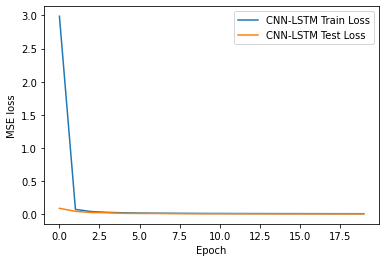

In [58]:
quick_test8(mer8motif_model_cnnlstm, oracle_8mer_motif)

mer8motif_cnnlstm_data_label = list(zip([mer8motif_train_losses_cnnlstm,mer8motif_test_losses_cnnlstm], ['CNN-LSTM Train Loss','CNN-LSTM Test Loss']))
u.quick_loss_plot(mer8motif_cnnlstm_data_label)

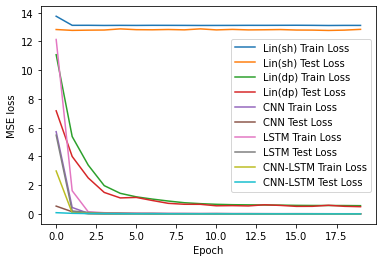

In [59]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label + \
    mer8motif_cnnlstm_data_label
)

Running LinearShallow_8mer


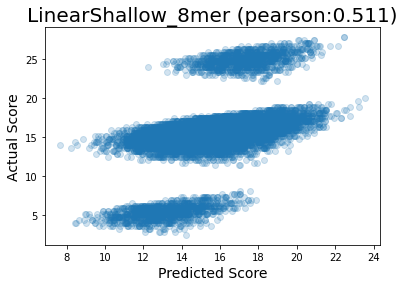

Running LinearDeep_8mer


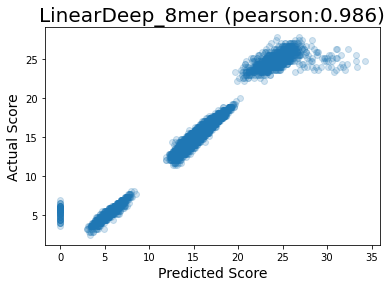

Running CNN_8mer


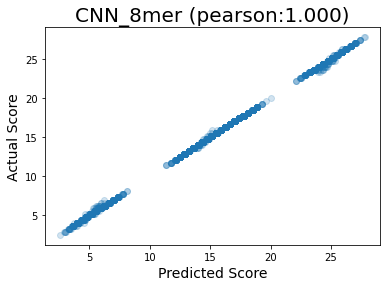

Running LSTM_8mer


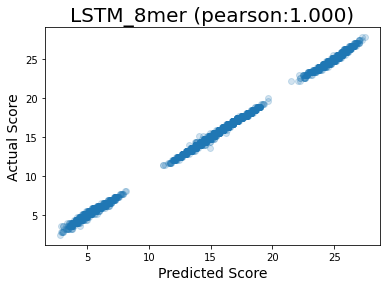

Running CNN+LSTM_8mer


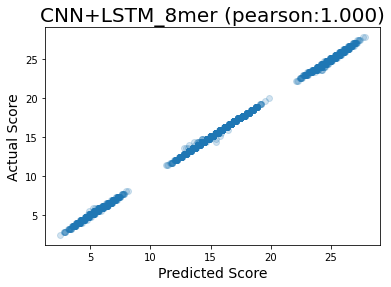

In [60]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s),
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
    ("LSTM_8mer",mer8motif_model_lstm),
    ("CNN+LSTM_8mer",mer8motif_model_cnnlstm),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

dfs = u.parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)